In [1]:
# importações necessárias para o algoritmo

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

C:\Users\Sirine\AppData\Local\conda\conda\envs\my_root\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_path = 'C:/Users/Sirine/Desktop/Maseer/201801a.txt'
output_path = 'D:\Cleaned.csv'

In [3]:
# Load in the dataset
full_data =  pd.read_csv('C:/Users/Sirine/Desktop/Maseer/201801a.txt',sep='\t', encoding="utf-8" ,names = ["Datetime","Time","ChargePointID","ChargePointType","Status","Latitude_Longitude","Address",    "Latitude","Longitude"])
# Clean empty rows
full_data = full_data.dropna(axis=0)

In [4]:
#convert Datetime to str to combine date (Datetime) and time (Time)
full_data.Datetime = full_data.Datetime.astype(str)

#convert Time to str to combine date (Datetime) and time (Time)
full_data.Time = full_data.Time.astype(str)
#add Time to Datetime column
full_data['Datetime'] = full_data['Datetime'].str.cat(full_data['Time'].values.astype(str), sep='')
#now I don't need the Time column anymone (since it was added to the Datetime column)
 

full_data['Date'] = full_data.Datetime.str.slice(0,8)
full_data['Time'] = full_data.Datetime.str.slice(8)
full_data['Time'] = full_data['Time'].apply(lambda val: '{:0>4}'.format(val))
full_data['Datetime'] = full_data['Date'] + " " + full_data["Time"]

#now let's finally convert Datetime to type datetime in column FormattedDatetime 

full_data['FormattedDatetime'] = pd.to_datetime(full_data.Datetime,format="%Y%m%d %H%M")
del full_data['Datetime']
del full_data['Date']
del full_data['Time']

full_data.head()

,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude,FormattedDatetime
0,CP:C6FD3,StandardType2,OOS,"-6.933468,52.836332","Public Car Park, Kennedy Street, Carlow Town, ...",-6.933468,52.836332,2018-01-01 00:01:00
1,CP:C7WLM,StandardType2,OOC,"-6.972487,53.917571","Main Street, Bailieborough, County Cavan",-6.972487,53.917571,2018-01-01 00:01:00
2,CP:C4FVM,StandardType2,OOS,"-9.346292,52.928911","Public Car Park, N67/Milltown Malbay Road, Lah...",-9.346292,52.928911,2018-01-01 00:01:00
3,CP:C6Q3G,StandardType2,OOC,"-8.889570,51.620831","Deasy's Public Car Park, Park Road (N71), Clon...",-8.889570,51.620831,2018-01-01 00:01:00
4,CP:C6J53,StandardType2,Part,"-8.473326,51.896298","51 South Mall, Cork City, County Cork",-8.473326,51.896298,2018-01-01 00:01:00


In [5]:

status_dummies = pd.get_dummies(full_data.Status).astype(int)
status_dummies.head()

,OOC,OOS,Occ,Part
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,1,0,0,0
4,0,0,0,1


In [6]:
#let's reappend the status features to the original dataset
full_data = pd.concat(
    [full_data,status_dummies],
    axis=1) #remember that concatenating columns means axis=1!
#full_data.drop('Status',inplace=True,axis=1) --> this would drop the Status column, but we will want that
full_data.head()

,ChargePointID,ChargePointType,Status,Latitude_Longitude,Address,Latitude,Longitude,FormattedDatetime,OOC,OOS,Occ,Part
0,CP:C6FD3,StandardType2,OOS,"-6.933468,52.836332","Public Car Park, Kennedy Street, Carlow Town, ...",-6.933468,52.836332,2018-01-01 00:01:00,0,1,0,0
1,CP:C7WLM,StandardType2,OOC,"-6.972487,53.917571","Main Street, Bailieborough, County Cavan",-6.972487,53.917571,2018-01-01 00:01:00,1,0,0,0
2,CP:C4FVM,StandardType2,OOS,"-9.346292,52.928911","Public Car Park, N67/Milltown Malbay Road, Lah...",-9.346292,52.928911,2018-01-01 00:01:00,0,1,0,0
3,CP:C6Q3G,StandardType2,OOC,"-8.889570,51.620831","Deasy's Public Car Park, Park Road (N71), Clon...",-8.889570,51.620831,2018-01-01 00:01:00,1,0,0,0
4,CP:C6J53,StandardType2,Part,"-8.473326,51.896298","51 South Mall, Cork City, County Cork",-8.473326,51.896298,2018-01-01 00:01:00,0,0,0,1


In [7]:

CS1=full_data.loc[full_data['ChargePointID'] == 'CP:C8PJ7'] 



In [8]:

CS1AVAIL = []
current = []
start = '2018-01-01 15:20:00'
time = pd.to_datetime(start)
#count = 0
while time <= pd.to_datetime('2018-1-31 19:52:00'):
    current.append('CP:C8PJ7') #ChargePointID
    current.append('StandardType2') #ChargePointType
    current.append('A') #Status = available
    current.append('Q-Park Multi-Storey Car Park, Sean McDermott Street, Dublin 1, County Dublin') #Address
    current.append(float(-6.258432)) #Latitude
    current.append(float(53.352022)) #citude
    current.append(pd.to_datetime(time)) #Datetime
    current.append(0) #OOC
    current.append(0) #OOS
    current.append(0) #Occ
    current.append(0) #Part
    CS1AVAIL.append(current)
    current = []
    time = pd.to_datetime(time) + pd.Timedelta(minutes=5)
   
 
 
 

In [9]:

#turn list into df
CS1AVAIL = pd.DataFrame(CS1AVAIL, columns=['ChargePointID',
                                                         'ChargePointType',
                                                         'Status',
                                                         'Address',
                                                         'Latitude',
                                                         'Longitude',
                                                         'FormattedDatetime',
                                                         'OOC',
                                                         'OOS',
                                                         'Occ',
                                                         'Part'])

 


In [10]:

"""I was getting an error when trying to update cliftonAVAIL with clifton,
so I reset the index of clifton, which fixed the problem"""
CS1 = CS1.reset_index()  
CS1AVAIL.update(CS1) 

In [11]:

CS1AVAIL['Status_Number'] = (CS1AVAIL.Status != 'A').astype(int)
  
CS1AVAIL.head()

status=CS1AVAIL.Status_Number

In [12]:
CS1AVAIL.to_csv(output_path)


In [13]:
 
    # salva em arquivo
    
CS1AVAIL.drop('ChargePointID',inplace=True,axis=1) 
CS1AVAIL.drop('ChargePointType',inplace=True,axis=1) 
CS1AVAIL.drop('Status',inplace=True,axis=1) 
CS1AVAIL.drop('Latitude',inplace=True,axis=1) 
CS1AVAIL.drop('Longitude',inplace=True,axis=1)  
CS1AVAIL.drop('Address',inplace=True,axis=1) 
CS1AVAIL.drop('Status_Number',inplace=True,axis=1)  

CS1AVAIL.head()
 

,FormattedDatetime,OOC,OOS,Occ,Part
0,2018-01-01 15:20:00,0.0,0.0,0.0,1.0
1,2018-01-01 15:25:00,0.0,0.0,0.0,1.0
2,2018-01-01 15:30:00,0.0,0.0,0.0,1.0
3,2018-01-01 15:20:00,0.0,0.0,0.0,1.0
4,2018-01-01 15:35:00,0.0,0.0,0.0,1.0


In [14]:
output_path = 'D:\Cleaned2.csv'

In [15]:

CS1AVAIL.to_csv(output_path)

In [16]:
 CS1AVAIL.drop('FormattedDatetime',inplace=True,axis=1)  
     


In [17]:

values = CS1AVAIL.values


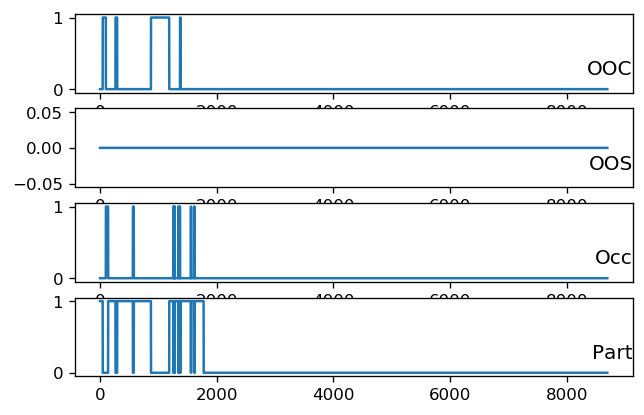

In [18]:
# plota cada coluna como um gráfico
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(CS1AVAIL.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [35]:
# converte as series para aprendizagem supervisionada
def series_to_supervised(data, n_x=24, n_y=1):
    n = n_x + 1
    df = DataFrame(data)
    i = 0
    df_len = len(df)
    
    samples = sample = df[0:n]
    df = df.shift(-1)
    df.dropna(inplace=True)
    samples = sample.values
    samples = samples.reshape(1,n,8)
    while(i < df_len-1):
        sample = df[0:n]
        if(sample.size == n*8):
            df = df.shift(-1)
            df.dropna(inplace=True)
            sample = sample.values
            sample = sample.reshape(1,n,8)
            samples = np.concatenate((samples, sample), axis=0)
        else:
            break
        i += 1
        
    return samples

# muda o tipo dos valores para ponto flutuante
values = values.astype('float64')

# normaliza a escala dos dados
scaled = np.log1p(values)

reframed = series_to_supervised(scaled)
 

ValueError: cannot reshape array of size 100 into shape (1,25,8)

In [36]:
# arquitetura da rede
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16, activation='relu'))   # vale a pena?
model.add(Dense(8))
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
]

# modela a rede
history = model.fit(train_X, train_y, 
                    epochs=1000, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=True, 
                    callbacks=callbacks)

# plota em grafico o historico de aprendizado e treino
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'train_X' is not defined

In [37]:
# faz uma predição
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'test_X' is not defined